# Imports

In [491]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
import scipy.stats

# Parameters

In [650]:
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
alpha_damage_propagation = 0.062    #Tasa de propagacion de daño
coupling_factor = 0.089             #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-4))     #Tasa de mortalidad

# Gillespie

In [651]:
@njit()
def Gillespie(trp0,tmax, N_total, disease_rate):
    """
    Esta funcion se emplea solamente para hacer la evolución de un paso individual en la celula. Evoluciona no un paso temporal, 
    pero si temporalmente la cantidad de veces que pueda evolucionar antes del tmax en una corrida
    """
    t,N, died =trp0 

    while t < tmax and not died :
        s_1 =  ((N_total-N)/(N_total))*(alpha_damage_propagation*N + disease_rate*N_total)
        s_2 = mortality_rate*((N/N_total)**(coupling_factor/alpha_damage_propagation))
        S_T = s_1 + s_2 

        τ = (-1/S_T)*np.log(np.random.rand())
        x = np.random.rand()

        if x <= (s_1)/S_T:
            N += 1
        else: 
            died = True
            break
        t+=τ
    return np.array([t,N, died]) 
@njit()
def Estado_celula(X0,tiempos, N_total, disease_rate):
    
    X = np.empty((len(tiempos),len(X0)))
    X[:] = np.nan
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i], N_total, disease_rate)
        if X[i][2]:
            break
    return X

# Experiments

In [741]:
N_total_steps = [7,15,30,45,60,75,90, 120, 150, 200, 300]
#disease_rate_steps = [0.0025, 0.005, 0.01, 0.02, 0.04]
disease_rate_steps = [0.00045]
simulaciones = np.empty((len(N_total_steps),len(disease_rate_steps)), dtype=object)

In [742]:
for idx_D, D in enumerate(tqdm(disease_rate_steps)):
    for idx_N, N in enumerate(tqdm(N_total_steps)):
        x0 = np.array([0., 0., False])
        num_cel = 1*(10**5) #Cantidad de personas que se estan simulando
        celulas = np.array([Estado_celula(x0,np.arange(0.,tiempo_vida_maximo,1.), N,D ) for i in range(num_cel)])
        simulaciones[idx_N][idx_D] = celulas

100%|██████████| 1/1 [00:59<00:00, 59.74s/it]


# Phenomenological Data

In [722]:
import csv
phenomenological_age = []
phenomenological_frailty_index = []
with open("Phenomenological_data.csv", 'r') as file:
  csvreader = csv.reader(file, delimiter=",")
  for fila in csvreader:
    phenomenological_age.append(float(fila[0]))
    phenomenological_frailty_index.append(float(fila[1]))

In [723]:
import csv
frailty_index_data_age = []
frailty_index_data_index = []
with open("frailty_index_data_GNM.csv", 'r') as file:
  csvreader = csv.reader(file, delimiter=",")
  for fila in csvreader:
    frailty_index_data_age.append(float(fila[0]))
    frailty_index_data_index.append(float(fila[1]))

In [730]:
N_total_steps = [200]
disease_rate_steps = [0.00025]
simulaciones = np.empty((len(N_total_steps),len(disease_rate_steps)), dtype=object)

for idx_D, D in enumerate(tqdm(disease_rate_steps)):
    for idx_N, N in enumerate(tqdm(N_total_steps)):
        x0 = np.array([0., 0., False])
        num_cel = 1*(10**5) #Cantidad de personas que se estan simulando
        celulas = np.array([Estado_celula(x0,np.arange(0.,tiempo_vida_maximo,1.), N,D ) for i in range(num_cel)])
        simulaciones[idx_N][idx_D] = celulas

curva_promedio_stochastic_model = np.zeros((len(simulaciones[0][0][0])))

for i in tqdm(np.arange((len(simulaciones[0][0][0])))):
    promedio = np.nanmean(simulaciones[0][0][:,i,1])/N_total_steps[0]
    curva_promedio_stochastic_model[i] = promedio

100%|██████████| 150/150 [00:00<00:00, 376.08it/s]


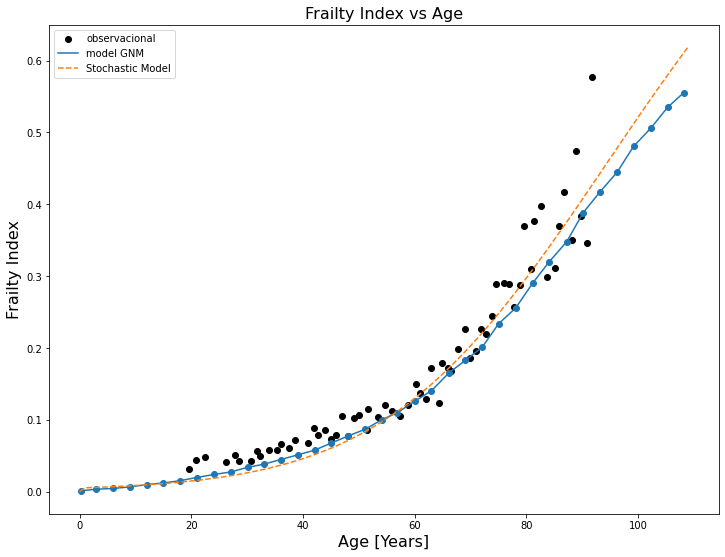

In [731]:
plt.figure(figsize = (12,9))
plt.title(r"Frailty Index vs Age", fontsize =16)
plt.scatter(phenomenological_age, phenomenological_frailty_index, color = "black", label = "observacional")
plt.scatter(frailty_index_data_age, frailty_index_data_index)
plt.plot(frailty_index_data_age, frailty_index_data_index, label = "model GNM")
plt.plot(curva_promedio_stochastic_model[0:110], label = "Stochastic Model", linestyle = "--")
plt.xlabel(r"Age [Years]", fontsize =16)
plt.ylabel(r"Frailty Index", fontsize =16)
plt.legend()

In [ ]:
promedio_1 = np.nanmean(simulaciones[0][0][:,i,1])/7

# Distribuciones P(f)

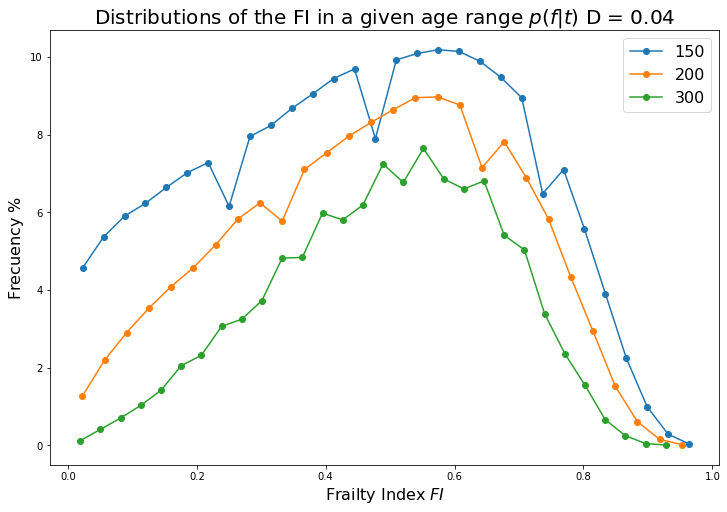

In [781]:
import matplotlib.pyplot as plt
import numpy as np

bins_histograma = [21,21,30,22,29,25,30,30,30,28,30]

datos_65_69 = np.empty((len(N_total_steps)), dtype=object)
hist_65_69 = np.empty((len(N_total_steps)), dtype=object)
max_points_65_69 = np.empty((len(N_total_steps)), dtype=object)

for i in range(8, len(N_total_steps)):
    dato = np.concatenate((simulaciones[i][0][:,80:85,1]))
    dato = dato[~np.isnan(dato)]

    datos_65_69[i] = dato
    hist, bin = np.histogram(datos_65_69[i], density=True, bins = bins_histograma[i] )


    max_point = bin[:-1] + np.diff(bin)/2
    max_points_filtered_a = max_point[hist > 0]

    hist = hist[hist > 0]

    hist_65_69[i] = hist*1000
    max_points_65_69[i] = max_points_filtered_a/N_total_steps[i]

plt.figure(figsize=(12,8))
plt.title(r"Distributions of the FI in a given age range $p(f|t)$ D = 0.04", fontsize = 20)
for i in range(8, len(N_total_steps)):

    plt.plot(max_points_65_69[i], hist_65_69[i], marker='o', label = f"{N_total_steps[i]}")


plt.xlabel(r'Frailty Index $FI$', fontsize = 16)
plt.ylabel(r'Frecuency $\%$', fontsize = 16)
plt.legend(fontsize = 16)
#plt.savefig("Distribution_frailty_disease_rate_004.jpg", dpi = 500)
plt.show()